# OCR 프로젝트 

태블릿 PC를 구매한 뒤로 책을 pdf로 스캔해서 그 안에 담고 다니는 일이 잦아졌는데, 가능할것이라고 생각했던 텍스트 찾기와 같은 기능들이 수행되지 않았다.  
왜 그런지 찾아보았더니, OCR이 적용되지 않은 스캔방식을 사용했던 것 이었다.  
지금까지는 OCR이 그렇게 중요한 기술은 아니었지만, 점점 발전하는 시대에는 아날로그 데이터들을 디지털화 시키는 등의 이유로 필수적이라고 생각이 들었다.  

> ## OCR?  
Optical Character Recognition(광학 문자 인식)의 약자로써 쉽게는 이미지를 통해서 텍스트를 인식하는 기술이라고 볼 수 있다.

딥러닝으로 구현된 OCR은 문자를 <span style= "color : orange">Detection(인식)</span>하고 그 문자를 <span style= "color : orange">Recognition(해독)</span>하는 과정을 거친다.  
그렇다면 딥러닝은 어떤 과정을 통해서 이를 수행할까?

구현하는 방식에 따라 다르겠지만, Google-OCR에서는 입력받은 이미지에서 문자의 위치를 찾아내고(문자검출), 찾은 문자 영역을 토대로 그 문자를 인식한다. OCR을 설명하는 아래 이미지에서는 사각형의 네 꼭지점 좌표를 알려주는 방법을 제시하고 있다.  
<img src = "https://aiffelstaticprd.blob.core.windows.net/media/images/E-19-4.max-800x600_lhFXcl2.png">  
[출처: https://brunch.co.kr/@kakao-it/318]  

이 이미지에서와 다르게 다른 표현방식이나 다른 도형을 사용할 수 있다는데  
그 점 보다는 궁금증이 들었다.  
``
이미지 안에서 텍스트가 기울어진 채로 Detection 되어도 잘 인식할까?  
``  
<img src= "(E-18)samples/스크린샷, 2021-03-21 18-52-58.png">  
[Scene Text Detection with Polygon Offsetting and Border Augmentation](https://www.mdpi.com/2079-9292/9/1/117/pdf) 에서는 위와 같은 표현 방식을 말했다.  
첫번째 이미지는 축을 중심으로 한 <span style= "color : orange">text instance</span>를 인식하고  
두번째 이미지는 축을 중심으로 한 <span style= "color : orange">bounding box</span>를,  
세번째 이미지는 <span style= "color : orange">quadrangle</span>로써,  
네번째 이미지는 <span style= "color : orange">text polygon</span>을 통해 인식한다고 한다.(자세히 보면 첫번째 이미지는 휘어짐과 상관없이 큰 박스, 두번째 이미지는 휘어짐에 따른 큰 박스, 세번째 이미지는 'Tea'부분에서의 마름모꼴, 네번째 이미지는 정확히 텍스트를 감싸는 폴리곤을 볼 수 있다)  


당연하지만, 네번째 이미지가 가장 정확하게 위치, 크기, 곡선형태의 텍스트를 표현할 수 있다고 했다.



다시 딥러닝으로 돌아와서, 최근 딥러닝 모델이 문자를 인식하는 방식으로는 Object detection(객체 인식)을 통해 접근한다. 
객체 인식 방법에는 <span style = "color : orange">Regression</span>과 <span style = "color : orange">Segmentation</span>이 있다.  
> Regression  
기준으로 하는 박스에 대비해 박스의 크기가 얼마나 차이나는가를 학습  

> Segmentation  
픽셀 단위로 해당 픽셀이 문자를 표현하는지 학습

딥러닝의 문자 인식을 고려하니 뒤로는 어떤 신경망이 사용될까 궁금증이 들었다.  
보통 이미지 데이터를 처리하는 CNN?  
텍스트를 인식하고 처리하니 RNN?  
어떻게 생각해보니 당연하게도 두 신경망을 결합한 CRNN 모델을 사용한다고 한다.  
이미지 - > 텍스트 생성의 과정을 거치기 때문일까? 라는 생각과 함께 예전에 cs231n에서 보았던  Image Captioning과도 비슷하지 않을까 라는 생각이 들었다.  
  
CRNN의 인공신경망을 도식화 하면 다음과 같다.  
<img src= "https://aiffelstaticprd.blob.core.windows.net/media/images/E-19-12.max-800x600_y9DP2Mu.png">[출처: Ibrahim, Ahmed Sobhy Elnady. End-To-End Text Detection Using Deep Learning. Diss. Virginia Tech, 2017. (https://arxiv.org/abs/1507.05717)]  

CNN을 통해서 이미지 안에서 찾을 수 있는 텍스트와 관련 지을 수 있는 특징을 CNN으로 추출 후 각 단계별 정보를 RNN을 거쳐서 인식하는 과정을 담고있다.  

개략적인 OCR과 딥러닝의 연관성 및 활용법을 알았기 때문에, 프로젝트를 진행했다.

## Google-OCR-API 

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

어느 정도 성능은 당연히 보장되겠지 하는 마음에 조금 특이한 훈민정음을 넣어봤다.

-rw-r--r-- 1 aiffel-dj16 aiffel-dj16 2355  3월 16 10:19 /home/aiffel-dj16/aiffel/ocr_python/my_google_api_key.json
Texts:

"나랏말싼미 둥력에 달아 문장와
우리 나라 말이 중국과 달라 한
로 서르 스롯디 아니 홀해, 이런
자와는 서로 잘 동하지 아니한
다. 이런 까닭으로 어리석은 백
전초로 어린 빅성이 너르고져 옳
배 이셔도 모춤내 제 뜨들 시러
성들이 말하고자 하는 바 있어도
펴디 몸홀 노미 하니라. 내 이름
마침내 세 듯을 펴지 못하는 사
윙호야 어엿비 너겨 새로 스물
람이 많다. 내가 이것을 가입게
생각하여 새로 스물여덟 글자를
예 수비 니겨 날로 쭈메 뻔만피 만드니. 모든 사람들로 하여금
여들 빙7노니 사용마다 히
t교져 홍 쓰로미니라.
쉬이 익혀서 날마다 쓰는 데 편
하게 하고자 할 따름이니라.
"

"나랏"

"말"

"싼미"

"둥력"

"에"

"달아"

"문장와"

"우리"

"나라"

"말이"

"중국"

"과"

"달라"

"한"

"로"

"서르"

"스"

"롯디"

"아니"

"홀해"

","

"이런"

"자"

"와"

"는"

"서로"

"잘"

"동"

"하지"

"아니한"

"다"

"."

"이런"

"까닭"

"으로"

"어리석은"

"백"

"전초"

"로"

"어린"

"빅성"

"이"

"너"

"르고"

"져"

"옳"

"배"

"이셔"

"도"

"모춤"

"내"

"제"

"뜨들"

"시러"

"성"

"들이"

"말"

"하고자"

"하는"

"바"

"있어도"

"펴디"

"몸홀"

"노미"

"하니라"

"."

"내"

"이름"

"마침내"

"세"

"듯"

"을"

"펴지"

"못하는"

"사"

"윙"

"호야"

"어엿비"

"너겨"

"새로"

"스물"

"람"

"이"

"많다"

"."

"내가"

"이것을"

"가입"

"게"

"생각"

"하여"

"새로"

"스물"

"여덟"

"글자"

"를

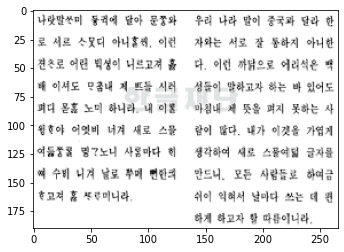

In [3]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.


path =  os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'


img = plt.imread(path)
plt.imshow(img)

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

생각보다 놀랍도록 뛰어난 성능을 보여줬다! 역시 구글이구나 싶었다.

Texts:

"함께 성장하며
행복을 나누는 금융
우하나금융그룹
더 빠른, 더 간편한, 더 혁신적인
디지털 금융플랫폼의 완성
더케이손해보험이 하나손해보험이 되었습니다
더 커진하나금융그룹이 새로운생활에 맞춘금융 플랫폼으로
핀테크 시대를선도하겠습니다
하나손해보험
하나금융자주· 하나은행. 하나금융루자· 하나카드· 하나캐피랄·하나생령. 하나손혜보험 . 하나자축은행. 하나자신신탁· 하나대체투자자신운용 · 하나에프멘아이, 하나벤처스· 하나린드서비스· 하나금융타아이· 핀크
"

"함께"

"성장"

"하며"

"행복"

"을"

"나누는"

"금융"

"우"

"하나"

"금융"

"그룹"

"더"

"빠른"

","

"더"

"간편한"

","

"더"

"혁신적인"

"디지털"

"금융"

"플랫폼"

"의"

"완성"

"더"

"케이"

"손해"

"보험"

"이"

"하나"

"손해"

"보험"

"이"

"되었습니다"

"더"

"커진"

"하나"

"금융"

"그룹"

"이"

"새로운"

"생활"

"에"

"맞춘"

"금융"

"플랫폼"

"으로"

"핀"

"테크"

"시대"

"를"

"선도"

"하겠습니다"

"하나"

"손해"

"보험"

"하나"

"금융"

"자주"

"·"

"하나"

"은행"

"."

"하나"

"금융"

"루자"

"·"

"하나"

"카드"

"·"

"하나"

"캐피"

"랄"

"·"

"하나"

"생령"

"."

"하나"

"손혜"

"보험"

"."

"하나"

"자축"

"은행"

"."

"하나"

"자신"

"신탁"

"·"

"하나"

"대체"

"투자"

"자신"

"운용"

"·"

"하나"

"에프"

"멘"

"아이"

","

"하나"

"벤처스"

"·"

"하나"

"린드"

"서비스"

"·"

"하나"

"금융"

"타"

"아이"

"·"

"핀크"
bounds: (657,921),(665,921),(665,932),(657,932)


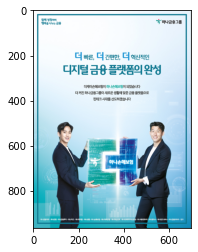

In [4]:
path =  os.getenv('HOME')+'/aiffel/ocr_python/test_image_1.jpg'


img = plt.imread(path)
plt.imshow(img)

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

두 번째 이미지에서도 크기와 색이 각각 임에도 그렇게 나쁘지 않은 결과를 보여줬다.

Texts:

"000
이 맛이
TERRA
TERRA
212EK 100% ENOF 100%
청정라거-테라
TERRA
TERRA
FROM AGM
"

"000"

"이"

"맛"

"이"

"TERRA"

"TERRA"

"212EK"

"100%"

"ENOF"

"100%"

"청정"

"라거"

"-"

"테라"

"TERRA"

"TERRA"

"FROM"

"AGM"
bounds: (356,232),(368,232),(368,236),(356,236)


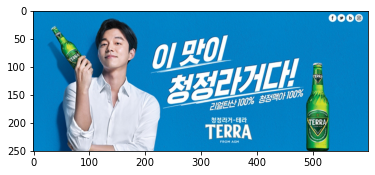

In [5]:
path =  os.getenv('HOME')+'/aiffel/ocr_python/test_image_2.jpg'


img = plt.imread(path)
plt.imshow(img)

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

별 것 아닌 이미지인 것 같지만, 의외로 다른 모델로 진행하면서 이 이미지에서 텍스트를 잘 검출해내지 못하는 것으로 봤을 때 뛰어난 성능을 보였다.

Texts:

"Washing &
LAUNDRY
Laundry
tools
Housework
washing
Clothing
Washing
tools
Laundry
sodp
"

"Washing"

"&"

"LAUNDRY"

"Laundry"

"tools"

"Housework"

"washing"

"Clothing"

"Washing"

"tools"

"Laundry"

"sodp"
bounds: (151,218),(172,218),(172,225),(151,225)


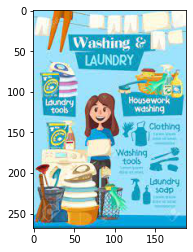

In [6]:
path =  os.getenv('HOME')+'/aiffel/ocr_python/test_image_3.jpeg'


img = plt.imread(path)
plt.imshow(img)

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

한글에서도 뛰어난 성능을 보였으니 당연히 잘되겠지 라고 생각하고 복잡해보이는 영어 이미지를 넣었는데, 작은 글자들에서는 의외로 오타를 보였다.

## keras-ocr

In [7]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel-dj16/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel-dj16/.keras-ocr/crnn_kurapan.h5


In [8]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
    'https://cdn.foodnews.co.kr/news/photo/202003/73081_29400_5726.jpg',
    'https://i1.wp.com/www.blogtowers.com/wp-content/uploads/2019/07/pepsi.png?fit=789%2C432',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQA5FjQT4XUY2iEwcjHYhJb8BNYxGaW3MU1IBwInURAg8OlHyeFcB01_3ie9NQbQVvMN_c&usqp=CAU'
    'https://5.imimg.com/data5/MK/VP/TO/SELLER-2650952/commercial-advertisement-service-500x500.jpg'
    
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


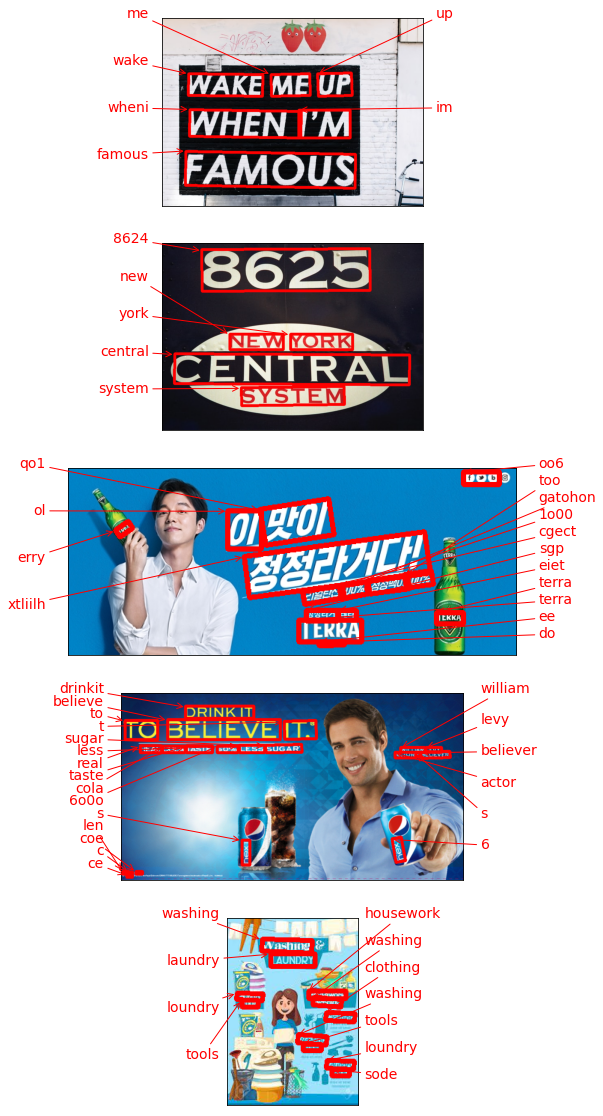

In [9]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

가장 큰 특징으로는 keras-ocr에서는 한글을 지원하지 않았다.  
keras-ocr에서는 검출기와 인식기를 두고 검출기로 문자 영역을 표시한 정보를 검출한 뒤에  
인식기가 그 박스를 토대로 문자를 인식하는 과정을 거친다.  

## Tecerract  
Tecerract는 한국어를 포함한 116 개 국어를 지원하며 구글의 후원을 받는다고 한다.  
또 큰 특징으로는 오픈소스라고 한다!

In [10]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/aiffel-dj16/aiffel/ocr_python/0000.png
/home/aiffel-dj16/aiffel/ocr_python/0001.png
/home/aiffel-dj16/aiffel/ocr_python/0002.png
/home/aiffel-dj16/aiffel/ocr_python/0003.png
/home/aiffel-dj16/aiffel/ocr_python/0004.png
/home/aiffel-dj16/aiffel/ocr_python/0005.png
/home/aiffel-dj16/aiffel/ocr_python/0006.png
/home/aiffel-dj16/aiffel/ocr_python/0007.png
/home/aiffel-dj16/aiffel/ocr_python/0008.png
/home/aiffel-dj16/aiffel/ocr_python/0009.png
/home/aiffel-dj16/aiffel/ocr_python/0010.png
/home/aiffel-dj16/aiffel/ocr_python/0011.png
/home/aiffel-dj16/aiffel/ocr_python/0012.png
/home/aiffel-dj16/aiffel/ocr_python/0013.png
/home/aiffel-dj16/aiffel/ocr_python/0014.png
/home/aiffel-dj16/aiffel/ocr_python/0015.png
/home/aiffel-dj16/aiffel/ocr_python/0016.png
/home/aiffel-dj16/aiffel/ocr_python/0017.png
/home/aiffel-dj16/aiffel/ocr_python/0018.png
/home/aiffel-dj16/aiffel/ocr_python/0019.png
/home/aiffel-dj16/aiffel/ocr_python/0020.png
/home/aiffel-dj16/aiffel/ocr_python/0021.png
/home/aiff

나라막쑤미

등귀에

담아

> ?와

로 셔르

스디

아니 호 케

이런

전츠로

어려

틱성이

 니르고져 을

때 이셔도

므 좀

내 제

…ㄴ글

시려

뼈니

로 호

누디

하니라 내

이토

윌호아

어인

비 녀겨

내로

스트

거들 기노

옆구노니

사도마다

이

져 수미 뇌겨

니도

| 메

뻔잔기

그저 호

< 이니라

우리

나라

방이

.ㅜ~ 싸

날라 한

자와ㄷㄷ

서로 장

토하시

아니한

다. 이런

가닭으로

여리식은 책

성둘이

바하 고

자 하는

바

키어 누

마침내 제

두음 펴지

못하는

다

람이

농대

냐가

어것옴

가업제

성각하여

녀 로

^~돌여덜

글 자들

카드녀

노라

나할들로

하미 근

거 이

익혀셔

낭마다

~

데

다져

하고자

할 따른이니라

.

Done


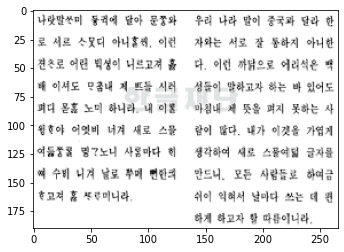

In [11]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

img = plt.imread(img_file_path)
plt.imshow(img)

/home/aiffel-dj16/aiffel/ocr_python/0000.png
/home/aiffel-dj16/aiffel/ocr_python/0001.png
/home/aiffel-dj16/aiffel/ocr_python/0002.png
/home/aiffel-dj16/aiffel/ocr_python/0003.png
/home/aiffel-dj16/aiffel/ocr_python/0004.png
/home/aiffel-dj16/aiffel/ocr_python/0005.png
/home/aiffel-dj16/aiffel/ocr_python/0006.png
/home/aiffel-dj16/aiffel/ocr_python/0007.png
/home/aiffel-dj16/aiffel/ocr_python/0008.png
/home/aiffel-dj16/aiffel/ocr_python/0009.png
/home/aiffel-dj16/aiffel/ocr_python/0010.png
/home/aiffel-dj16/aiffel/ocr_python/0011.png
/home/aiffel-dj16/aiffel/ocr_python/0012.png
/home/aiffel-dj16/aiffel/ocr_python/0013.png
/home/aiffel-dj16/aiffel/ocr_python/0014.png
/home/aiffel-dj16/aiffel/ocr_python/0015.png
/home/aiffel-dj16/aiffel/ocr_python/0016.png
/home/aiffel-dj16/aiffel/ocr_python/0017.png
/home/aiffel-dj16/aiffel/ocr_python/0018.png
/home/aiffel-dj16/aiffel/ocr_python/0019.png
/home/aiffel-dj16/aiffel/ocr_python/0020.png
/home/aiffel-dj16/aiffel/ocr_python/0021.png
/home/aiff

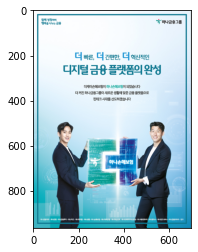

In [12]:
img_file_path = work_dir + '/test_image_1.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

img = plt.imread(img_file_path)
plt.imshow(img)

/home/aiffel-dj16/aiffel/ocr_python/0000.png
- ;

Done


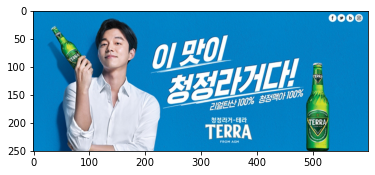

In [13]:
img_file_path = work_dir + '/test_image_2.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

img = plt.imread(img_file_path)
plt.imshow(img)

/home/aiffel-dj16/aiffel/ocr_python/0000.png

Done


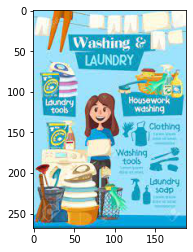

In [14]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

img_file_path = work_dir + '/test_image_3.jpeg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

img = plt.imread(img_file_path)
plt.imshow(img)

tecerract는 생각보다 좋은 성능을 내지 못했다. 텍스트가 기울어져 있거나, 크기가 일정하지 않고, 약간의 노이즈 모든 요소 마다 꽤 많은 성능하락의 요인이 크게 작용한 것 같다.

## 회고  
내가 가장 먼저 중요하다고 생각한 것은 이미지 안에서의 텍스트의 크기, 모양에 민감하게 반응하지 않는 모델이 좋은 모델이라고 생각했다. 이런 기준으로 Tecerract는 가장 약세를 보였다. 또, 노이즈 및 정확도 측면에서 봤을 때도, google api, keras-ocr 보다 더 자연스럽지 못한 결과를 냈다. 이러한 성능 차이에 빗대어 위에서 언급한 각 모델의 표현방법이 궁금했다. 당연히 텍스트 폴리곤을 사용할지, 아니면 다른 것을 통해 표현할지 말이다. 또한 어떠한 차이에서 꽤나 극명하게 차이나는 결과를 보이는지 궁금했다. OCR에 대해서는 더욱 깊게 알고싶다는 생각이 드는 프로젝트 였다! 